In [1]:
from commons.data_processing import *
from commons.my_mzml import*
from matplotlib.ticker import FormatStrFormatter
from commons.byonic import ByFile
import os 
import re 
import ntpath
import numpy as np 
import pandas as pd 
import altair as alt 
import matplotlib.pyplot as plt

In [2]:
files = get_files('.', exts=['.xlsx'])

In [3]:
def categorize_glycan(s):
    s = s.replace(')', ',')
    s = s.replace('(', ' ')
    s = s.split(',')[:-1]
    d = {k:int(v) for [k, v] in [i.split(' ') for i in s]}

    if 'NeuAc' in d or 'NeuGc' in d:
        return 'Sialylated'
    elif 'Fuc' in d:
        if d['HexNAc'] > 2:
            return 'Fucosylated'
        elif d['HexNAc'] == 2:
            if 'Hex' in d:
                if d['Hex'] > 4:
                    return 'Complex'
                else:
                    return 'Paucimannose' 
    # elif 'Fuc' in d and d['HexNAc'] > 2:
    #     return 'Fucosylated'
    elif d['HexNAc'] > 2:
        return 'Complex'
    if d['HexNAc'] <= 2:
        if 'Hex' in d:
            if d['Hex'] <= 9 and d['Hex'] > 4:
                return 'High Mannose'
        return 'Paucimannose'

In [4]:
subset = ["clean_peptide", "glycan", "z", "observed_mz",
          "calc._mass_mh", "glycosite", "score", "delta_mod",
          "log_prob", "peptide", "protein_name", "scan_time"]
agg = pd.DataFrame()
for file in files:
    exp = file.split('\\')[1]
    base = ntpath.basename(file)
    base, _ = ntpath.splitext(base)
    spl = base.split('_')
    base, temp = spl[0], spl[1]
    print(f'Parsing file {file}')
    bf = ByFile(file)
    bf.fill_no_glycans()
    bf.remove_reverse(modify=True)
    bf.determine_glycosites()
    bf.filter_hits(modify=True, score=100)
    bf.frame = bf.reduce_frame(cols=subset, gp_only=True)
    total = bf.total_gp()
    total.loc[:, 'experiment'] = [exp]*len(total)
    total.loc[:, 'column'] = [base]*len(total)
    total.loc[:, 'temperature'] = [temp]*len(total)
    total.loc[:, 'condition'] = ['_'.join([base, temp])]*len(total)
    if agg.empty:
        agg = total
        continue
    agg = pd.concat([agg, total], axis=0)
agg.loc[:, 'glycan_type'] = agg.glycan.map(categorize_glycan)

Parsing file .\NT1\BP_30C\BP_30C.xlsx
Parsing file .\NT1\BP_45C\BP_45C.xlsx
Parsing file .\NT1\BP_60C\BP_60C.xlsx
Parsing file .\NT1\C18_30C\C18_30C.xlsx
Parsing file .\NT1\C18_45C\C18_45C.xlsx
Parsing file .\NT1\C18_60C\C18_60C.xlsx
Parsing file .\NT1\PGC_30C\PGC_30C.xlsx
Parsing file .\NT1\PGC_45C\PGC_45C.xlsx
Parsing file .\NT1\PGC_60C\PGC_60C.xlsx
Parsing file .\StdEnr\BP_30C\BP_30C.xlsx
Parsing file .\StdEnr\BP_45C\BP_45C.xlsx
Parsing file .\StdEnr\BP_60C\BP_60C.xlsx
Parsing file .\StdEnr\C18_30C\C18_30C.xlsx
Parsing file .\StdEnr\C18_45C\C18_45C.xlsx
Parsing file .\StdEnr\C18_60C\C18_60C.xlsx
Parsing file .\StdEnr\PGC_30C\PGC_30C.xlsx
Parsing file .\StdEnr\PGC_45C\PGC_45C.xlsx
Parsing file .\StdEnr\PGC_60C\PGC_60C.xlsx
Parsing file .\T10\BP_30C\BP_30C.xlsx
Parsing file .\T10\BP_45C\BP_45C.xlsx
Parsing file .\T10\BP_60C\BP_60C.xlsx
Parsing file .\T10\C18_30C\C18_30C.xlsx
Parsing file .\T10\C18_45C\C18_45C.xlsx
Parsing file .\T10\C18_60C\C18_60C.xlsx
Parsing file .\T10\PGC_30C\PGC_

In [5]:
hm_nt30 = agg[(agg.experiment=='NT1') & (agg.glycan_type=='High Mannose') &
                  (agg.column=='C18') & (agg.temperature=='30C')].drop_duplicates()
hm_nt45 = agg[(agg.experiment=='NT1') & (agg.glycan_type=='High Mannose') &
                  (agg.column=='C18') & (agg.temperature=='45C')].drop_duplicates()
hm_nt60 = agg[(agg.experiment=='NT1') & (agg.glycan_type=='High Mannose') &
                  (agg.column=='C18') & (agg.temperature=='60C')].drop_duplicates()

hm_nt60[hm_nt60.clean_peptide=='VWNSTFIEDYR']

,clean_peptide,glycan,z,observed_mz,calc._mass_mh,glycosite,score,delta_mod,log_prob,peptide,protein_name,scan_time,experiment,column,temperature,condition,glycan_type
3758,VWNSTFIEDYR,HexNAc(2)Hex(9),3,1098.7796,3294.3088,936,143.45,21.98,2.76,R.VWN[+1864.634]STFIEDYR.D,>sp|P26006|ITA3_HUMAN Integrin alpha-3 OS=Homo...,41.7763,NT1,C18,45C,C18_45C,High Mannose
3759,VWNSTFIEDYR,HexNAc(2)Hex(8),3,1044.7620,3132.2560,936,207.83,33.70,2.90,R.VWN[+1702.581]STFIEDYR.D,>sp|P26006|ITA3_HUMAN Integrin alpha-3 OS=Homo...,42.2469,NT1,C18,45C,C18_45C,High Mannose


In [10]:
def extract(data, search_value, tolerance=10):
    low, high = mass_tolerance(search_value, tolerance)
    xs, ys = [], []
    for scan in data:
        xs.append(scan[0])
        ids = np.where(np.logical_and(scan[1] >= low, scan[1] <= high))
        if len(ids[0]) > 0:
            ys.append(np.max(scan[2][ids]))
        else:
            ys.append(0)
    return np.array(xs), np.array(ys)

In [13]:
xmls = get_files(r'E:\Research\MS Data\QE-HF\20201115_NT1T10Glyco', exts=['.mzXML'])
xmls = xmls[12:15]
labels = ['30C', '45C', '60C']
data = {}
for i, label in enumerate(labels):
    m = mzXML(xmls[i])
    data[label] = m.ms1_data

In [9]:
hm_scrape = hm_nt45[hm_nt45.peptide.isin(hm_nt60.peptide) & ~hm_nt45.peptide.isin(hm_nt30.peptide)]
hm_scrape.head()

,clean_peptide,glycan,z,observed_mz,calc._mass_mh,glycosite,score,delta_mod,log_prob,peptide,protein_name,scan_time,experiment,column,temperature,condition,glycan_type
926,NCTSISGDLHILPVAFR,HexNAc(2)Hex(6),3,1093.4922,3278.4502,362,161.29,55.30,3.07,K.N[+1378.476]C[+57.021]TSISGDLHILPVAFR.G,>sp|P00533|EGFR_HUMAN Epidermal growth factor ...,49.2249,NT1,C18,45C,C18_45C,High Mannose
1374,YHYNCSLLDGTQLFTSHDYGAPQEATLGANK,HexNAc(2)Hex(8),4,1294.3010,5174.1723,408,101.24,67.41,4.32,R.YHYN[+1702.581]C[+57.021]SLLDGTQLFTSHDYGAPQE...,>sp|Q96AY3|FKB10_HUMAN Peptidyl-prolyl cis-tra...,46.8259,NT1,C18,45C,C18_45C,High Mannose
1661,VFGSQNLTTVK,HexNAc(2)Hex(7),3,912.0727,2734.1810,516,143.96,24.13,2.02,R.VFGSQN[+1540.529]LTTVK.L,>sp|Q9Y4L1|HYOU1_HUMAN Hypoxia up-regulated pr...,26.3470,NT1,C18,45C,C18_45C,High Mannose
1690,LSALDNLLNHSSMFLK,HexNAc(2)Hex(8),3,1169.1889,3505.5283,831,200.11,104.59,5.23,R.LSALDNLLN[+1702.581]HSSMFLK.G,>sp|Q9Y4L1|HYOU1_HUMAN Hypoxia up-regulated pr...,56.7229,NT1,C18,45C,C18_45C,High Mannose
1714,AEPPLNASASDQGEK,HexNAc(2)Hex(8),3,1072.7760,3216.2942,932,168.66,82.27,5.71,R.AEPPLN[+1702.581]ASASDQGEK.V,>sp|Q9Y4L1|HYOU1_HUMAN Hypoxia up-regulated pr...,14.9077,NT1,C18,45C,C18_45C,High Mannose


NCTSISGDLHILPVAFR + HexNAc(2)Hex(6)
YHYNCSLLDGTQLFTSHDYGAPQEATLGANK + HexNAc(2)Hex(8)
VFGSQNLTTVK + HexNAc(2)Hex(7)
LSALDNLLNHSSMFLK + HexNAc(2)Hex(8)
AEPPLNASASDQGEK + HexNAc(2)Hex(8)
VNVTVEDER + HexNAc(2)Hex(7)
NATASLWSGPGLEDR + HexNAc(2)Hex(6)
DSEAFCHANCSGPAPAAKPDPDGGR + HexNAc(2)Hex(8)
DSEAFCHANCSGPAPAAKPDPDGGR + HexNAc(2)Hex(7)
EEAMLYHNQTAELR + HexNAc(2)Hex(9)
AQEALSMGNATFYEVESILK + HexNAc(2)Hex(6)
AQEALSMGNATFYEVESILK + HexNAc(2)Hex(6)
NMSFVNDLTVTQDGR + HexNAc(2)Hex(6)
EQINITLDHR + HexNAc(2)Hex(8)
EQINITLDHR + HexNAc(2)Hex(7)
EQINITLDHR + HexNAc(2)Hex(9)
YNCSIESPR + HexNAc(2)Hex(7)
VNNTLSSQISR + HexNAc(2)Hex(6)
VNNTLSSQISR + HexNAc(2)Hex(8)
TANDTSTEAYNLLLR + HexNAc(2)Hex(8)
TLAGENQTAFEIEELNR + HexNAc(2)Hex(8)
KIPAINQTITEANEK + HexNAc(2)Hex(8)
NITIVTGAPR + HexNAc(2)Hex(9)
VWNSTFIEDYR + HexNAc(2)Hex(9)
VWNSTFIEDYR + HexNAc(2)Hex(8)
DMSDGFISNLTIQR + HexNAc(2)Hex(6)
GLNLTEDTYKPR + HexNAc(2)Hex(8)
LKPLFNK + HexNAc(2)Hex(6)
VTTYCNETMTGWVHDVLGR + HexNAc(2)Hex(7)
VDGQLVNLTLVEGR + HexNAc(

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



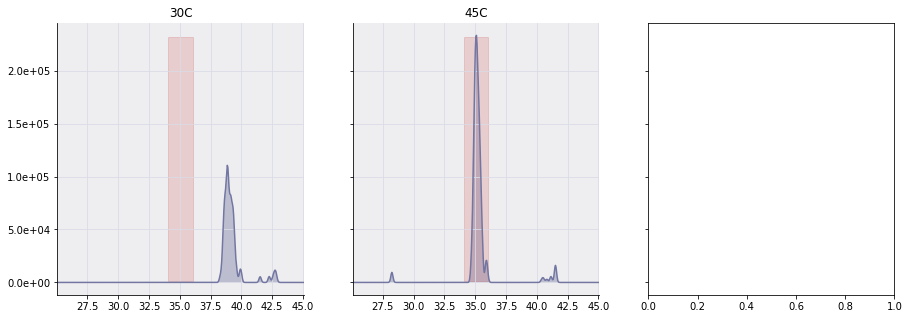

In [15]:
temps, heights = [], []

for row in hm_scrape.itertuples():
    sequence = row[1]
    mod = row[2]
    mass = row[4] 
    time=row[-6]
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    labels = ['30C', '45C', '60C']
    text_y = 0
    for i, ax in enumerate(axs.flat):
        key = labels[i]
        array = data[key]
        xs, ys = extract(array, mass, tolerance=3)
        
        peak_window = np.where(np.logical_and(xs >= time-1, xs <= time+1))
        peak_ys = ys[peak_window]
        temps.append(labels[i])
        heights.append(np.max(peak_ys))
        
        window = np.where(np.logical_and(xs >= time-10, xs <= time+10))
        xs, ys = xs[window], ys[window]
        ys = gaussian_filter(ys, 2)

        ax.plot(xs, ys, color='#7276a1')
        ax.fill_between(xs, 0, ys, facecolor='#7276a1', alpha=0.4)
        ax.set_xlim(time-10, time+10)

        # ax.vlines([time-2, time+2], 0, np.max(ys), color='#D04B4B')
        ax.axvspan(time-1, time+1, ymin=0.05, ymax=0.95, alpha=0.2, color='#D04B4B')

        _, y_max = ax.get_ylim()
        text_y = np.max([text_y, y_max])

        # add identifying text
        ax.set_title(labels[i])
        
        # format plots
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
        ax.set_facecolor('#EEEEF0')
        ax.grid(True, color='#dadbe6')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)


    for i, ax in enumerate(axs.flat):
        ax.text(time + 9.0, text_y * 0.85, f'm/z: {mass:.2f}', ha='right')
    title_text = ' + '.join([sequence, mod])
    plt.suptitle(title_text)
    print(title_text)
#     plt.savefig(f'./Cross_Sample_Comparisons/C18_Peak_Contrasts/High Mannose/{title_text}.png')
#     plt.savefig(f'./Cross_Sample_Comparisons/C18_Peak_Contrasts/High Mannose/{title_text}.svg')
    plt.close()

In [ ]:
# extract MS2 data for representative peptide
m = mzXML(xmls[0])
x45, y45 = m.get_scan('14862')
m = mzXML(xmls[1])
x60, y60 = m.get_scan('14766')

In [149]:
peak_heights = pd.DataFrame({
    'label':temps,
    'value':heights
})

box = alt.Chart(peak_heights).mark_boxplot().encode(
    x=alt.X('label:O', title=''),
    y=alt.Y('mean(value):Q', title='')
)
box.save(f'./Cross_Sample_Comparisons/C18_Peak_Contrasts/MS1_Peak_Height.svg')
box.save(f'./Cross_Sample_Comparisons/C18_Peak_Contrasts/MS1_Peak_Height.png')
box

alt.Chart(...)

In [5]:
xmls = get_files(r'E:\Research\MS Data\QE-HF\20201115_NT1T10Glyco', exts=['.mzXML'])
xmls = xmls[3:6]
print(xmls)
labels = ['30C', '45C', '60C']
data = {}
for i, label in enumerate(labels):
    m = mzXML(xmls[i])
    data[label] = m.ms1_data

['E:\\Research\\MS Data\\QE-HF\\20201115_NT1T10Glyco\\20201115_GD_EnrGly_1115_C18_30C_run1.mzXML', 'E:\\Research\\MS Data\\QE-HF\\20201115_NT1T10Glyco\\20201115_GD_EnrGly_1115_C18_45C_run1.mzXML', 'E:\\Research\\MS Data\\QE-HF\\20201115_NT1T10Glyco\\20201115_GD_EnrGly_1115_C18_60C_run1.mzXML']


In [17]:
sial_s30 = agg[(agg.experiment=='StdEnr') & (agg.glycan_type=='Sialylated') &
                  (agg.column=='C18') & (agg.temperature=='30C')].drop_duplicates()
sial_s45 = agg[(agg.experiment=='StdEnr') & (agg.glycan_type=='Sialylated') &
                  (agg.column=='C18') & (agg.temperature=='45C')].drop_duplicates()
sial_s60 = agg[(agg.experiment=='StdEnr') & (agg.glycan_type=='Sialylated') &
                  (agg.column=='C18') & (agg.temperature=='60C')].drop_duplicates()

sial_scrape = sial_s30[sial_s30.peptide.isin(sial_s45.peptide) & sial_s30.peptide.isin(sial_s60.peptide)]


In [19]:
temps, heights = [], []

for row in sial_scrape.itertuples():
    sequence = row[1]
    mod = row[2]
    mass = row[4] 
    time=row[-6]
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    labels = ['30C', '45C', '60C']
    text_y = 0
    for i, ax in enumerate(axs.flat):
        key = labels[i]
        array = data[key]
        xs, ys = extract(array, mass, tolerance=3)
        
        peak_window = np.where(np.logical_and(xs >= time-1, xs <= time+1))
        peak_ys = ys[peak_window]
        temps.append(labels[i])
        heights.append(np.max(peak_ys))
        
        window = np.where(np.logical_and(xs >= time-10, xs <= time+10))
        xs, ys = xs[window], ys[window]
        ys = gaussian_filter(ys, 2)

        ax.plot(xs, ys, color='#7276a1')
        ax.fill_between(xs, 0, ys, facecolor='#7276a1', alpha=0.4)
        ax.set_xlim(time-10, time+10)

        _, y_max = ax.get_ylim()
        text_y = np.max([text_y, y_max])

        # add identifying text
        ax.set_title(labels[i])
        
        # format plots
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
        ax.set_facecolor('#EEEEF0')
        ax.grid(True, color='#dadbe6')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)


    for i, ax in enumerate(axs.flat):
        ax.text(time + 9.0, text_y * 0.85, f'm/z: {mass:.2f}', ha='right')
    title_text = ' + '.join([sequence, mod])
    plt.suptitle(title_text)
    print(title_text)
    plt.savefig(f'./Cross_Sample_Comparisons/C18_Peak_Contrasts/Sialylated/{title_text}.png')
    plt.savefig(f'./Cross_Sample_Comparisons/C18_Peak_Contrasts/Sialylated/{title_text}.svg')
    plt.close()

NPEYNK + HexNAc(4)Hex(5)NeuAc(1)
NPEYNK + HexNAc(5)Hex(6)NeuGc(1)
NPEYNK + HexNAc(4)Hex(5)NeuGc(2)
NPEYNK + HexNAc(5)Hex(6)NeuAc(1)
NPEYNK + HexNAc(4)Hex(5)NeuAc(3)
NPEYNK + HexNAc(5)Hex(6)NeuAc(2)
NPEYNK + HexNAc(4)Hex(5)NeuAc(2)NeuGc(1)
NPEYNK + HexNAc(5)Hex(6)NeuAc(2)NeuGc(1)
NPEYNK + HexNAc(4)Hex(5)NeuAc(2)
NPEYNK + HexNAc(4)Hex(5)NeuAc(1)NeuGc(1)
NPEYNK + HexNAc(4)Hex(5)NeuAc(1)NeuGc(2)
NPEYNK + HexNAc(4)Hex(5)NeuGc(2)
NPEYNK + HexNAc(5)Hex(6)NeuAc(1)NeuGc(1)
NPEYNK + HexNAc(4)Hex(6)Fuc(1)NeuAc(1)
NPEYNK + HexNAc(4)Hex(5)NeuAc(3)
NPEYNK + HexNAc(4)Hex(6)NeuAc(1)
NPEYNK + HexNAc(4)Hex(5)NeuAc(1)
NPEYNK + HexNAc(5)Hex(6)NeuAc(3)
NPEYNK + HexNAc(4)Hex(5)NeuAc(2)
NPEYNK + HexNAc(4)Hex(5)NeuAc(1)NeuGc(1)
NPEYNK + HexNAc(4)Hex(5)NeuAc(1)NeuGc(2)
NPEYNK + HexNAc(5)Hex(6)NeuGc(1)
NPEYNK + HexNAc(4)Hex(5)Fuc(1)NeuAc(1)
NPEYNK + HexNAc(5)Hex(6)NeuAc(1)
NPEYNK + HexNAc(5)Hex(6)NeuAc(3)
NPEYNK + HexNAc(5)Hex(6)NeuAc(2)NeuGc(1)
NPEYNK + HexNAc(5)Hex(6)NeuAc(2)
NPEYNK + HexNAc(4)Hex(5)NeuAc(2)N